# Datascience project : movie recommandation with LSH

dataset : [MovieLens Dataset](https://grouplens.org/datasets/movielens/) 

- remove users that have only one rating
- test set: 1 random rating for each user in the dataset
- train set: all the other ratings
- Warning: do not include the zeros when you compute the RMSE on the test/train

In [28]:
import pandas as pd
from pathlib import Path
import numpy as np
# from datasketch import MinHash, MinHashLSHForest
from math import isnan
from itertools import permutations
import matplotlib.pyplot as plt
import random
import plotly.express as px

In [29]:
# read input ratings dataframe
ratings_df=pd.read_csv(Path("..","ml-latest-small","ratings.csv"))
ratings_df.drop("timestamp",inplace=True,axis=1)

In [76]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [30]:
ratings_df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


Text(0.5, 1.0, 'Ratings distribution')

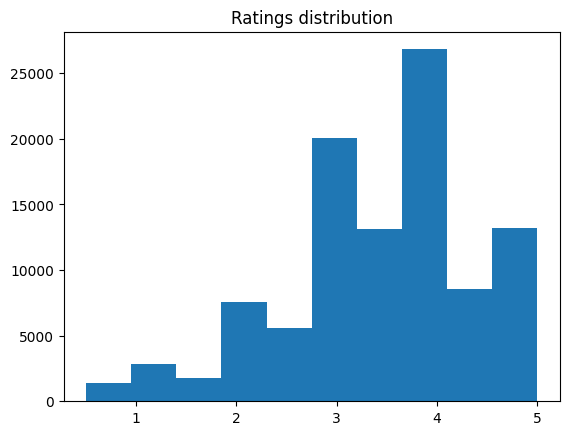

In [31]:
plt.hist(ratings_df.rating)
plt.title("Ratings distribution")

In [32]:
nb_users=ratings_df["userId"].nunique()
nb_films=ratings_df["movieId"].nunique()
print(f"There are {nb_users} unique users and {nb_films} unique films. {nb_users*nb_films} combinations")
input_df=ratings_df.pivot_table(values='rating', index="userId", columns='movieId').rename_axis(None, axis=1).rename_axis(None, axis=0)

There are 610 unique users and 9724 unique films. 5931640 combinations


In [33]:
input_df

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Shingles : help reducing dimension of the data or describing the data (for example by outputing all bi grams in a text document)
- we will consider all the movies that have a rating above threshold $m$ : $f(r_{ij})=1 \text{ iff } r_{ij}>m$
- possible hashing functions :
    - Minhash
    - random vectors and dot product
    - minhash : place where the max rating is present for a user


In [34]:
rating_threshold=3
np_df=input_df.to_numpy()


# replace nan values by 0
# np_df=np.nan_to_num(np_df,nan=0)
np_df=np.where(np_df>=rating_threshold,1,np.nan)

final_df=pd.DataFrame(np_df,index=input_df.index,columns=input_df.columns)
init_users_nb=final_df.shape[0]

# remove all candidates that have only rated films below the threshold (they don't add any information)
nb_evaluations=final_df.apply(lambda row : sum([k for k in row if not isnan(k)]),axis=1)
candidates_to_drop=nb_evaluations.index[nb_evaluations<1]
# remove all people that have only rated one movie
serie_count_non_na=input_df.notna().sum(axis=1)
list(candidates_to_drop).extend(serie_count_non_na)

final_df.drop(candidates_to_drop,axis=0,inplace=True)
print(f"After removing the irrelevent users, there are {final_df.shape[0]} users left : removed {init_users_nb - final_df.shape[0]}")


After removing the irrelevent users, there are 609 users left : removed 1


In [35]:
final_df

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Split dataset into train and test

In [36]:
final_df.notna()

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1,True,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
607,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
608,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
609,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [37]:
def choose_random_rating(row):
    # non_nan_ratings=row.notna()
    chosen_movie_rating_index=random.choice(row.index[row.notna()])
    corresponding_rating=row[chosen_movie_rating_index]
    return chosen_movie_rating_index

In [38]:
row=final_df.iloc[0]
choose_random_rating(row)

3243

In [39]:
row=final_df.loc[71]
random.choice(row.index[row.notna()])

95

In [40]:
final_df.apply(choose_random_rating,axis=1)

1       2470
2      71535
3       7991
4       3386
5         58
       ...  
606     3295
607     1282
608     2890
609      339
610     1300
Length: 609, dtype: int64

# Similarity

In [42]:
def jaccard_similarity(a,b):
    """
    a,b are rows
    """
    set_a=set(a.index[a.notna()])
    set_b=set(b.index[b.notna()])
    inter_len=len(set.intersection(set_a,set_b))
    return inter_len/len(a)
    

# Minhash

In [43]:
#Number of Permutations
nb_permutations = 64

In [44]:
def generate_minhash(dataframe,permutation):
    # dataframe=pd.DataFrame(dataframe)
    permutated_df=dataframe[permutation]
    minhash_df=permutated_df.apply(pd.Series.first_valid_index,axis=1).sort_index()
    return minhash_df

In [27]:
generate_minhash(pd.DataFrame(input_df),permutation)

NameError: name 'permutation' is not defined

In [45]:
# %%time
np.random.seed(123)
permutation=np.random.permutation(input_df.columns)

generate_minhash(pd.DataFrame(input_df.iloc[3]).T,permutation)

4    2973
dtype: int64

In [46]:
# create the hash using minhash function
hash_table=[]
permutations_list=[]
perm_dfs=[]
np.random.seed(123)
for k in range(nb_permutations):
    #lets make permutations on the movies
    print(k,end="\r")
    permutation=np.random.permutation(input_df.columns)
    
    #take the permutation of the initial dataframe
    minhash_df=generate_minhash(input_df,permutation=permutation)
    hash_table.append(minhash_df)
    permutations_list.append(permutation)

    # break
    

In [47]:
hash_df=pd.DataFrame(hash_table).T

In [48]:
hash_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,3793,2141,2389,1644,2948,1210,1270,3440,1032,50,...,47,1348,2115,1073,2005,2916,2291,3147,1954,2268
2,99114,58559,58559,115713,318,109487,109487,68157,106782,114060,...,131724,68157,91529,318,77455,68157,91658,3578,74458,6874
3,72378,5048,1124,3703,7991,6238,914,2424,72378,1093,...,6238,3949,2090,6835,849,5746,720,1302,7991,72378
4,2973,4246,2692,492,222,3809,1025,2109,3788,2770,...,47,1086,1617,1073,599,912,4226,342,3481,232
5,21,410,253,153,515,150,318,266,608,50,...,153,247,357,318,34,253,253,457,110,232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,48638,4246,4056,6376,7584,4745,1270,2424,2541,50,...,47,1610,7036,60069,8724,3953,2445,1101,2405,7008
607,241,3016,3361,25,3785,1210,1270,3363,2858,1394,...,366,1610,2115,1270,1385,2881,3476,1101,1954,2268
608,3793,8810,3148,2549,5630,1210,1270,4270,2541,50,...,47,4396,2115,2003,4321,3953,4226,4980,1059,6541
609,833,356,828,288,590,150,318,10,339,292,...,1056,786,892,786,329,253,253,833,1059,731


# Applying the LSH algo

In [49]:
n_bands=32
band_size=2
# check consistency of the hash table
assert(n_bands*band_size==nb_permutations)

### Grouping together according to same hashes

In [50]:
hash_array= hash_df.to_numpy()
hashes={}
for band_index in range(n_bands):
    # going through the hash dataframes and extracting bands
    bande=hash_array[:,band_size*band_index:(band_index+1)*band_size]
    hash_band={}
    for user_index,user in enumerate(bande):
        current_sign=','.join([str(el) for el in user])
        hash_band[current_sign]=hash_band.get(current_sign,list()) + [str(user_index +1)]
        hashes[band_index]=hash_band
    

### Compute similarities of the grouped items

In [66]:
# hashes

In [51]:
# randomly select a user from the set 
user_id=123
user_row=input_df.loc[user_id]

In [52]:
# compute the user's signature 
hashes_user=[]
for k,permutation in enumerate(permutations_list) :
    print(f"Permutation {k}",end="\r")
    sign=generate_minhash(pd.DataFrame(user_row).T,permutation=permutation).values[0]
    hashes_user.append(sign)

In [68]:
# hashes_user

In [53]:
# find corresponding buckets
dict_sign_user={}
for band_index in range(n_bands):
    # going through the hash dataframes and extracting bands
    bande=hashes_user[band_size*band_index:(band_index+1)*band_size]
    dict_sign_user[band_index]=','.join([str(el) for el in bande])

In [54]:
dict_sign_user[0]

'99114,112852'

In [55]:
def find_similar_users(dict_sign_user):
    similar_users=[]
    # go through all the bands and find where the signatures match
    for band_index in dict_sign_user.keys():
        user_signature=dict_sign_user[band_index]
        simi_users_band=hashes[band_index].get(user_signature,[])
        similar_users.extend(simi_users_band)
    return list(set(similar_users))

In [56]:
similar_users=find_similar_users(dict_sign_user)

In [70]:
len(similar_users)

41

## Finding the infered rating for a random film for the specified user
Using formula 
$rating(u,i)=\sum_{k similar}\text{sim}(u,v_k).\text{Rating}(v_k,i)$

In [72]:
# random.seed(123)
# choosing a random movie
random_movie=random.choice(input_df.columns)
random_movie

2184

In [73]:
def infered_rating(user_row,similar_users,df_input,movie_index):
    rating=0
    for user in similar_users:
        if isnan(df_input.loc[int(user),movie_index]):
            continue
        similarity=jaccard_similarity(user_row,df_input.loc[int(user)])
        rating+=similarity*df_input.loc[int(user),movie_index]
    return rating

In [75]:
infered_rating(user_row=user_row,similar_users=similar_users,df_input=input_df,movie_index=random_movie)

0

## Compute all the infered rating for a user

In [61]:
dict_pred_ratings={}
for movie_index in input_df.columns:
    dict_pred_ratings[movie_index]=infered_rating(user_row=user_row,similar_users=similar_users,df_input=input_df,movie_index=movie_index)


In [62]:
infered_ratings= pd.DataFrame(dict_pred_ratings,index=[0])

In [63]:
infered_ratings.apply(pd.DataFrame.describe, axis=1)


,count,mean,std,min,25%,50%,75%,max
0,9724.0,0.006542,0.019975,0.0,0.0,0.0,0.0,0.30543


In [64]:
# display rating distribution for user
px.histogram(infered_ratings.loc[0].to_numpy())